# CSC412 Project (transformer part)
#### Author: Xinyi Ji

I write the code mainly based on these youtube videos:
- https://www.youtube.com/watch?v=U0s0f995w14
- http://jalammar.github.io/illustrated-transformer/
- https://www.youtube.com/watch?v=4Bdc55j80l8
- https://www.youtube.com/watch?app=desktop&v=dichIcUZfOw&ab_channel=Hedu-MathofIntelligence

And of course the transformer paper "Attention is all you need".

The whole model and traning process is the following:

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import pandas as pd
import torch.utils.data as data

## Data preprocessing

In [2]:
df = pd.read_csv('transformer_data.csv')
df.columns = range(256+1024)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,0,0,0,0,0,0,0,0,0,0,8,10,0,3,0,0,1,0,0,0,0,0,0,4,9,6,0,1,3,0,0,3,0,0,0,0,1,1,0,0,...,5232,209,2676,109,8031,127,4605,6384,510,3022,6271,2497,3224,4407,2006,5214,2629,5629,5214,5536,5643,4972,1177,1087,3414,5536,4547,7628,5239,1255,6583,7148,6565,3188,4312,6262,448,1732,215,4120
1,0,0,0,0,0,0,0,0,0,0,3,9,0,3,0,0,0,0,0,0,0,0,0,11,10,4,0,0,0,0,0,0,0,2,0,0,1,0,0,0,...,2557,1971,5385,30,2336,1778,199,560,6674,2532,7596,3123,2558,7453,5045,3927,2483,5698,2862,6165,5517,170,6460,5813,5897,3230,3533,7976,684,6770,1291,5470,3610,2133,6686,108,4834,3610,5542,1244
2,0,0,0,0,0,0,0,0,0,0,12,9,0,4,0,0,0,0,0,0,0,0,0,3,9,5,0,1,6,0,0,1,0,1,0,0,3,0,0,0,...,6791,4609,1917,3862,943,5916,1601,540,5363,4448,390,2560,2786,1147,4552,3916,671,2410,6791,6648,6875,7870,3830,3152,2114,5479,6443,6304,4283,6850,3441,6419,2014,390,4809,6227,5031,1680,1018,1309
3,0,0,0,0,0,0,0,0,0,2,8,9,0,4,0,0,1,0,0,0,0,0,0,5,8,5,0,1,2,0,0,1,0,1,0,0,4,0,0,0,...,6004,5403,7180,5668,2653,2327,5689,7781,6958,1600,7823,4007,6721,4621,4950,2690,5175,2684,2418,2952,3096,7012,4800,5477,2737,3851,7463,101,4583,7189,3404,5868,383,2548,6361,2576,2119,8011,4340,6000
4,0,0,0,0,0,0,0,0,0,0,7,11,0,1,0,0,0,0,0,0,0,0,0,3,8,6,0,0,2,0,0,2,0,1,0,0,1,0,0,1,...,4979,6587,6241,6473,4759,1830,5048,332,4472,2791,795,6322,6583,8148,5718,3759,5998,1534,5951,2849,4234,6101,6330,541,5978,2433,4950,5608,4165,5623,2177,2576,2464,825,4920,6289,61,4492,2061,704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0,0,0,0,0,0,0,0,0,13,0,9,0,3,0,0,0,0,0,0,0,0,0,0,10,3,0,0,2,0,0,1,0,0,0,0,0,0,0,0,...,5516,1929,7510,4785,6265,5156,5725,4155,2343,2063,6559,4736,3054,2190,2047,7133,5951,6710,8019,4734,5807,7022,5288,202,5650,1698,3959,2826,4377,10,2167,7537,6297,4441,7141,729,5452,4844,3572,6243
3996,0,0,0,0,0,0,0,0,0,14,0,9,0,3,0,0,0,0,0,0,0,0,0,0,10,4,0,2,3,0,0,0,0,0,0,0,0,0,0,0,...,2805,5466,5835,2161,2793,5573,5172,3754,7882,1672,2657,5324,4670,4442,7389,2924,8125,7468,4139,6310,7014,5782,1615,2448,1254,35,3454,225,1677,4575,5377,5668,4580,5891,6103,7455,7689,421,7673,2918
3997,0,0,0,0,0,0,0,0,0,15,0,10,0,2,0,0,0,0,0,0,0,0,0,0,10,3,0,1,2,0,0,2,0,0,0,0,0,0,0,0,...,4509,202,3071,6258,2831,4522,7673,3046,4106,592,6258,5623,4670,4419,7321,7451,1787,2896,960,4670,592,592,592,592,3260,592,592,2896,916,6295,4106,4522,2896,592,592,3260,7986,2896,2830,1938
3998,0,0,0,0,0,0,0,0,0,11,0,8,0,3,0,0,0,0,0,0,0,0,0,3,10,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,...,1304,6861,4305,4888,6958,7942,1950,1788,3641,7640,2756,3672,2736,5295,6363,3685,7697,1841,1415,615,7314,2080,7583,4748,6141,865,213,2707,4042,6928,7479,974,5778,7583,5375,15,5995,2399,7804,20


In [3]:
txt_col = range(256)
img_col = range(256,1024+256)
df_txt = df[txt_col]
df_img = df[img_col]
txt_array = df_txt.values
img_array = df_img.values
all_data = df.values
all_data = torch.from_numpy(all_data)

In [4]:
all_data.shape[0]

4000

In [5]:
def split_train_test(data, train_fraq=0.9): 
 n_samples = data.shape[0] 
 data_train = data[:int(n_samples * train_fraq)] 
 data_test = data[int(n_samples * train_fraq):] 
 return data_train, data_test 

In [6]:
all_data = split_train_test(all_data)

In [7]:
all_data[0].shape

torch.Size([3600, 1280])

In [8]:
train_X = all_data[0][:, :256]
train_y = all_data[0][:,256:]
test_X =  all_data[1][:, :256]
test_y = all_data[1][:,256:]

In [9]:
def dataloader(dataset, **kwargs): 
  if 'shuffle' not in kwargs: 
    kwargs['shuffle'] = True 
  if 'drop_last' not in kwargs: 
    kwargs['drop_last'] = True 
  if 'batch_size' not in kwargs: 
    kwargs['batch_size'] = 32 
  if 'num_workers' not in kwargs: 
    kwargs['num_workers'] = 8 
    kwargs['batch_size'] = min(kwargs['batch_size'], len(dataset)) 
  return data.DataLoader(dataset, **kwargs) 

In [10]:
# Train data is a tensor
batch_size = 10
num_workers = 8
train_dataset = data.TensorDataset(train_X, train_y) 
test_dataset = data.TensorDataset(test_X, test_y) 
train_dataloader = dataloader(train_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True) 
test_dataloader = dataloader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model:

In [11]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        # Get number of training examples
        N = query.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)  # (N, value_len, heads, head_dim)
        keys = self.keys(keys)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out

In [12]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

In [13]:
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length = 256,
    ):

        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(
            (self.word_embedding(x) + self.position_embedding(positions))
        )

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

In [14]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.norm = nn.LayerNorm(embed_size)
        self.attention = SelfAttention(embed_size, heads=heads)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

In [15]:
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length = 1024,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device),
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device),
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device),
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device),
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, row_mask,col_mask,conv_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

        x = self.layers[0](x, enc_out, enc_out, src_mask, row_mask)
        x = self.layers[1](x, enc_out, enc_out, src_mask, col_mask)
        x = self.layers[2](x, enc_out, enc_out, src_mask, row_mask)
        x = self.layers[3](x, enc_out, enc_out, src_mask, row_mask)
        x = self.layers[4](x, enc_out, enc_out, src_mask, conv_mask)

        out = self.fc_out(x)

        return out

In [16]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=512,
        num_layers=6,
        forward_expansion=4,
        heads=8,
        dropout=0,
        device="gpu",
        max_length=1024,
    ):

        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            256,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            1024,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)

    def make_row_mask(self, trg):
        N, trg_len = trg.shape

        # trg_len = 32 * 32 = 1024
        assert (
            1024 == trg_len
        ), "The size of image vector is 1024"

        y_axis = torch.range(0, 1023).expand(1024,1024)
        x_axis = torch.transpose(torch.range(0, 1023).expand(1024,1024), 0, 1)
        trg_mask = ((y_axis<x_axis).long() + (y_axis+32>x_axis).long() -1).bool()

        trg_mask = trg_mask.expand(N, 1, trg_len, trg_len)

        return trg_mask.to(self.device)
    
    def make_col_mask(self, trg):
        N, trg_len = trg.shape
        # trg_len = 32 * 32 = 1024

        assert (
            1024 == trg_len
        ), "The size of image vector is 1024"

        trg_mask = torch.zeros(1024, 1024)
        for i in range(32):
          cur_dia = torch.ones((1, 1024-32*i))[0]
          cur_mask = torch.diag(cur_dia,-32*i)
          trg_mask = trg_mask + cur_mask

        trg_mask = trg_mask.expand(N, 1, trg_len, trg_len)

        return trg_mask.to(self.device)
    
    def make_conv_mask(self, trg):
      # I am not sure how to deal with this(I searched online without finding the result),hence I will use row mask instead as they have similar performance
        N, trg_len = trg.shape
        # trg_len = 32 * 32 = 1024
        assert (
            1024 == trg_len
        ), "The size of image vector is 1024"

        y_axis = torch.range(0, 1023).expand(1024,1024)
        x_axis = torch.transpose(torch.range(0, 1023).expand(1024,1024), 0, 1)
        trg_mask = ((y_axis<x_axis).long() + (y_axis+32>x_axis).long() -1).bool()

        trg_mask = trg_mask.expand(N, 1, trg_len, trg_len)

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        # src_mask = self.make_src_mask(src)
        # trg_mask = self.make_trg_mask(trg)

        src_mask = self.make_src_mask(src)
        row_mask = self.make_row_mask(trg)
        col_mask = self.make_col_mask(trg)
        conv_mask = self.make_conv_mask(trg)

        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, row_mask,col_mask,conv_mask)
        return out

## Training loop

In [17]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(device)
# trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)

# src_pad_idx = 0
# trg_pad_idx = 0
# src_vocab_size = 10
# trg_vocab_size = 10
# model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device).to(device)
# out = model(x, trg[:, :-1])
# print(out.shape)

In [18]:
# criterion = nn.CrossEntropyLoss()
# input = torch.tensor([[[3.2, 1.3,0.2, 0.8],[3.2, 1.3,0.2, 0.8],[3.2, 1.3,0.2, 0.8]],[[3.2, 1.3,0.2, 0.8],[3.2, 1.3,0.2, 0.8],[3.2, 1.3,0.2, 0.8]]],dtype=torch.float)
# input = torch.transpose(input, 1, 2)
# target = torch.tensor([[0,1,2],[2,3,1]], dtype=torch.long)
# criterion(input, target).item()

In [19]:
# input  # batch=2 * voc=4(C) * ques_len=3

In [20]:
# target   # batch=2  * ques_len=3

In [21]:
def loss_function(org_img, trg_img):
  org_img = org_img[:,1:] # batch(N) * ques_len
  trg_img = trg_img[:,:-1, :] # batch(N) * ques_len * voc_size
  
  criterion = nn.CrossEntropyLoss()
  input = trg_img
  input = torch.transpose(input, 1, 2)
  target = org_img
  return criterion(input, target)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "gpu")
print(device)

train_loss_list = []
test_loss_list = []

src_pad_idx = 0
trg_pad_idx = 0
src_vocab_size = 51
trg_vocab_size = 8192
model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device).to(device)

optimizer = Adam(model.parameters(), lr=1e-4)

print("Start training VAE...")
model.train()

global_step = 0
pause_iters = 1
for epoch in range(100):
    overall_loss = 0
    for batch_idx, (x, y) in enumerate(train_dataloader):
        x = x.to(device) 
        y = y.to(device) 

        optimizer.zero_grad()

        trg_img = model(x, y) # (N, query_len, trg_vocab_size) 
        loss = loss_function(y, trg_img)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage traning Loss: ", overall_loss / (batch_idx*batch_size))
    train_loss_list.append(overall_loss / (batch_idx*batch_size))

    global_step += 1
    if global_step % pause_iters == 0:
      test_loss = 0
      with torch.no_grad():
        model.eval()
        for batch_idx, (x, y) in enumerate(test_dataloader):
          x = x.to(device) 
          y = y.to(device) 
          trg_img = model(x, y) # (N, query_len, trg_vocab_size) 
          loss = loss_function(y, trg_img)
          test_loss += loss.item()   
        print("\tAverage validation Loss: ", test_loss / (batch_idx*batch_size))
        test_loss_list.append(test_loss / (batch_idx*batch_size))
        model.train()
print("Finish!!")

cuda
Start training VAE...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start

	Epoch 1 complete! 	Average traning Loss:  0.8783163073335185
	Average validation Loss:  0.902344412681384
	Epoch 2 complete! 	Average traning Loss:  0.8761059628223642
	Average validation Loss:  0.9012905023036859
	Epoch 3 complete! 	Average traning Loss:  0.8759795024202395
	Average validation Loss:  0.9008156507443159
	Epoch 4 complete! 	Average traning Loss:  0.8654701612785998
	Average validation Loss:  0.881072814647968
	Epoch 5 complete! 	Average traning Loss:  0.8434814989732833
	Average validation Loss:  0.8678542650662936
	Epoch 6 complete! 	Average traning Loss:  0.8279045253743036
	Average validation Loss:  0.8536655108133951
	Epoch 7 complete! 	Average traning Loss:  0.8164356074957463
	Average validation Loss:  0.8461380469493377
	Epoch 8 complete! 	Average traning Loss:  0.8078529441589101
	Average validation Loss:  0.8401278202350323
	Epoch 9 complete! 	Average traning Loss:  0.8004614431545927
	Average validation Loss:  0.8379301144526555
	Epoch 10 complete! 	Average t

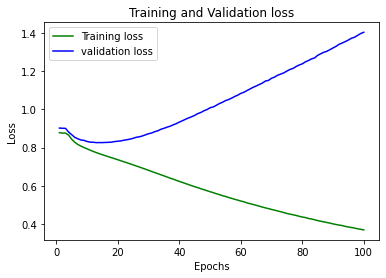

In [23]:
import matplotlib.pyplot as plt
loss_train = train_loss_list
loss_val = test_loss_list
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
torch.save({'model': model.state_dict()}, 'transformer_model.ckpt')

## Generate image vector

Implement in transformer_generate file.